# Laboratorio 1 Phishing detection
## Security Data Science
### Universidad del valle de Guatemala

Abner Ivan Garcia - 21285
Oscar Esteba Donis - 21610


In [1]:
import pandas as pd
import numpy as np
import re
from collections import Counter
from sklearn import feature_extraction, tree, model_selection, metrics
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline
from yellowbrick.features import Rank2D
from yellowbrick.features import RadViz

# Parte 1 - Ingeniería de características

In [2]:
df = pd.read_csv('dataset_pishing.csv')
print (df.shape)
print(df.head())
print(df.info())

# ejemplos de dominios del dataset (legitimos)
df[df.status == 'legitimate'].sample(5)

(11430, 2)
                                                 url      status
0              http://www.crestonwood.com/router.php  legitimate
1  http://shadetreetechnology.com/V4/validation/a...    phishing
2  https://support-appleld.com.secureupdate.duila...    phishing
3                                 http://rgipt.ac.in  legitimate
4  http://www.iracing.com/tracks/gateway-motorspo...  legitimate
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11430 entries, 0 to 11429
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   url     11430 non-null  object
 1   status  11430 non-null  object
dtypes: object(2)
memory usage: 178.7+ KB
None


,url,status
10592,https://amywestbrook.wordpress.com/,legitimate
8806,http://www.dictionary.com/browse/curry,legitimate
8983,https://www.tube8.com/gay/,legitimate
10959,http://hardware-store-vashon.downloads.filetra...,legitimate
1941,http://www.highspeed-internet-providers.com/ci...,legitimate


In [3]:
# Ejemplos de dominios del dataset (phishing)
df[df.status == 'phishing'].sample(5)

,url,status
2485,http://chronicle.co.kr/wp/wp-content/themes/tw...,phishing
7952,http://secure-microsoft-online.oa.r.appspot.co...,phishing
231,http://topprioritys.appspot.com/u?purl=b2Qubml...,phishing
11336,http://www.pastimenangqq101.com/wp-content/upl...,phishing
3812,http://www.thenine9.com/wp-admin/identifyuser....,phishing


In [4]:
# Contar la cantidad de observaciones para cada etiqueta de la columna 'status'
conteo_status = df.status.value_counts()

# Mostrando los resultados
print("La cantidad de observaciones para cada etiqueta de la columna 'status' de legitimo es:", conteo_status['legitimate'])
print("La cantidad de observaciones para cada etiqueta de la columna 'status' de phishing es:", conteo_status['phishing']) 

La cantidad de observaciones para cada etiqueta de la columna 'status' de legitimo es: 5715
La cantidad de observaciones para cada etiqueta de la columna 'status' de phishing es: 5715


R// Si esta balanceado

## Derivación de caracteristicas

#### 1. ¿Qué ventajas tiene el análisis de una URL contra el análisis de otros datos, cómo el tiempo de vida del dominio, o las características de la página Web?
R// El análisis de una URL destaca por su eficiencia, especificidad y adaptabilidad. A diferencia de analizar el tiempo de vida de un dominio o las características generales de una página web, la URL proporciona acceso directo y conciso a la información relevante. Permite un análisis más preciso y específico, enfocándose en elementos particulares como palabras clave o estructura, sin necesidad de procesar datos adicionales. Además, su flexibilidad permite adaptarse a diversos contextos y objetivos, desde clasificar páginas web hasta detectar malware, superando las limitaciones de otros análisis de datos menos versátiles.

#### 2. ¿Qué características de una URL son más prometedoras para la detección de phishing?
R//
1. Longitud de la URL
2. Cantidad de digitos en la URL
3. Entropia (Shannon) de la URL
4. Entropia (Relativa) de la URL
5. Proporcion entre vocales y consonantes
6. Posicion del primer digito en la URL
7. Presencia de direccion IP en la URL
8. Caracteres especiales en la URL
9. Presencia de puertos en la URL
10. Cantidad de subdominios
11. Cantidad de terminos comunes en URL (www, .com, http, https, etc)
12. Presencia de guiones bajos en la URL
13. Presencia de guiones en la URL
14. URL acortada
15. Subdominios abnormales

En base a la respuesta anterior escriba al menos quince funciones basadas en los artículos, para
derivar características que un modelo pueda utilizar y añada dichas características al dataset original. Incluya dentro de las quince funciones, la entropía de Shanon y relativa.

In [6]:
import re
import math
import tldextract
import pandas as pd
from urllib.parse import urlparse
from collections import Counter
import numpy as np

def url_length(url):
    return len(url)

def digit_count(url):
    return sum(c.isdigit() for c in url)

def shannon_entropy(url):
    """
    Calculate Shannon entropy of URL string
    Returns entropy value between 0 and log2(len(unique_chars))
    """
    try:
        # Calculate probability of each character
        prob = [float(url.count(c)) / len(url) for c in dict.fromkeys(list(url))]
        # Calculate entropy using probability distribution
        entropy = -sum(p * np.log2(p) for p in prob)
        return entropy
    except:
        return 0

def relative_entropy(url):
    """
    Calculate relative entropy (Kullback-Leibler divergence) of URL
    compared to expected character frequencies in legitimate URLs
    """
    try:
        # Preprocess URL
        url = url.replace('www.', '')
        url = url.split('://')[-1]
        url = url.split('.')[0]
        url = url.lower()
        
        # Expected character probabilities (based on Alexa Top 1M domains)
        probabilities = {
            '-': 0.013342298553905901,
            'a': 0.07333590631143488,
            'b': 0.04293204925644953,
            'c': 0.027385633133525503,
            'd': 0.02769469202658208,
            'e': 0.07086192756262588,
            'f': 0.01249653250998034,
            'g': 0.038516276096631406,
            'h': 0.024017645001386995,
            'i': 0.060447396668797414,
            'j': 0.007082725266242929,
            'k': 0.01659570875496002,
            'l': 0.05815885325582237,
            'm': 0.033884915513851865,
            'n': 0.04753175014774523,
            'o': 0.09413783122067709,
            'p': 0.042555148167356144,
            'q': 0.0017231917793349655,
            'r': 0.06460084667060655,
            's': 0.07214640647425614,
            't': 0.06447722311338391,
            'u': 0.034792493336388744,
            'v': 0.011637198026847418,
            'w': 0.013318176884203925,
            'x': 0.003170491961453572,
            'y': 0.016381628936354975,
            'z': 0.004715786426736459
        }
        
        # Calculate observed frequencies
        length = float(len(url))
        if length == 0:
            return 0
            
        char_counts = Counter(url)
        
        # Calculate relative entropy
        entropy = 0.0
        for char, count in char_counts.items():
            if char in probabilities:
                observed = count / length
                expected = probabilities[char]
                entropy += observed * np.log2(observed / expected)
        
        return entropy
    except:
        return 0

def vowel_consonant_ratio(url):
    vowels = sum(1 for c in url if c.lower() in 'aeiou')
    consonants = sum(1 for c in url if c.isalpha() and c.lower() not in 'aeiou')
    return vowels / consonants if consonants > 0 else 0

def first_digit_position(url):
    match = re.search(r'\d', url)
    return match.start() if match else -1

def contains_ip(url):
    return bool(re.search(r'\b(?:\d{1,3}\.){3}\d{1,3}\b', url))

def special_chars_count(url):
    return len(re.findall(r'[^a-zA-Z0-9]', url))

def contains_port(url):
    parsed = urlparse(url)
    return bool(parsed.port)

def subdomain_count(url):
    extracted = tldextract.extract(url)
    return extracted.subdomain.count('.')

def common_terms_count(url):
    common_terms = {'www', 'http', 'https', 'com', 'net', 'org', 'edu'}
    return sum(url.lower().count(term) for term in common_terms)

def contains_underscore(url):
    return '_' in url

def contains_dash(url):
    return '-' in url

def is_shortened(url):
    shortened_services = {"bit.ly", "goo.gl", "tinyurl.com", "t.co", "ow.ly", "is.gd", "buff.ly"}
    extracted = tldextract.extract(url)
    return extracted.domain in shortened_services

def abnormal_subdomains(url):
    extracted = tldextract.extract(url)
    return len(extracted.subdomain) > 20

# Preprocesamiento de datos

In [7]:
df['url_length'] = df['url'].apply(url_length)
df['digit_count'] = df['url'].apply(digit_count)
df['shannon_entropy'] = df['url'].apply(shannon_entropy)
df['relative_entropy'] = df['url'].apply(relative_entropy)
df['vowel_consonant_ratio'] = df['url'].apply(vowel_consonant_ratio)
df['first_digit_position'] = df['url'].apply(first_digit_position)
df['contains_ip'] = df['url'].apply(contains_ip)
df['special_chars_count'] = df['url'].apply(special_chars_count)
df['contains_port'] = df['url'].apply(contains_port)
df['subdomain_count'] = df['url'].apply(subdomain_count)
df['common_terms_count'] = df['url'].apply(common_terms_count)
df['contains_underscore'] = df['url'].apply(contains_underscore)
df['contains_dash'] = df['url'].apply(contains_dash)
df['is_shortened'] = df['url'].apply(is_shortened)
df['abnormal_subdomains'] = df['url'].apply(abnormal_subdomains)

print(df.head())

                                                 url      status  url_length  \
0              http://www.crestonwood.com/router.php  legitimate          37   
1  http://shadetreetechnology.com/V4/validation/a...    phishing          77   
2  https://support-appleld.com.secureupdate.duila...    phishing         126   
3                                 http://rgipt.ac.in  legitimate          18   
4  http://www.iracing.com/tracks/gateway-motorspo...  legitimate          55   

   digit_count  shannon_entropy  relative_entropy  vowel_consonant_ratio  \
0            0         3.787043          1.221603               0.363636   
1           17         4.419864          0.792675               0.827586   
2           19         4.753412          1.117812               0.517241   
3            0         3.461320          1.919763               0.300000   
4            0         4.097662          1.778614               0.363636   

   first_digit_position  contains_ip  special_chars_count  con

In [8]:
df_final = df
df_final = df_final.drop(['url'], axis=1)
df_final.to_csv('dataset_pishing_final.csv', index=False)
df_final.head()

,status,url_length,digit_count,shannon_entropy,relative_entropy,vowel_consonant_ratio,first_digit_position,contains_ip,special_chars_count,contains_port,subdomain_count,common_terms_count,contains_underscore,contains_dash,is_shortened,abnormal_subdomains
0,legitimate,37,0,3.787043,1.221603,0.363636,-1,False,7,False,0,3,False,False,False,False
1,phishing,77,17,4.419864,0.792675,0.827586,32,False,7,False,0,2,False,False,False,False
2,phishing,126,19,4.753412,1.117812,0.517241,62,False,19,False,2,4,True,True,False,True
3,legitimate,18,0,3.461320,1.919763,0.300000,-1,False,5,False,0,1,False,False,False,False
4,legitimate,55,0,4.097662,1.778614,0.363636,-1,False,10,False,0,3,False,True,False,False


In [9]:
df_final.dtypes

status                    object
url_length                 int64
digit_count                int64
shannon_entropy          float64
relative_entropy         float64
vowel_consonant_ratio    float64
first_digit_position       int64
contains_ip                 bool
special_chars_count        int64
contains_port               bool
subdomain_count            int64
common_terms_count         int64
contains_underscore         bool
contains_dash               bool
is_shortened                bool
abnormal_subdomains         bool
dtype: object

# Seleccion de Caracteristicas

Duplicated rows: 117

Features with low variance (<0.01):
contains_ip      0.009017
contains_port    0.002357
is_shortened     0.000000
dtype: float64


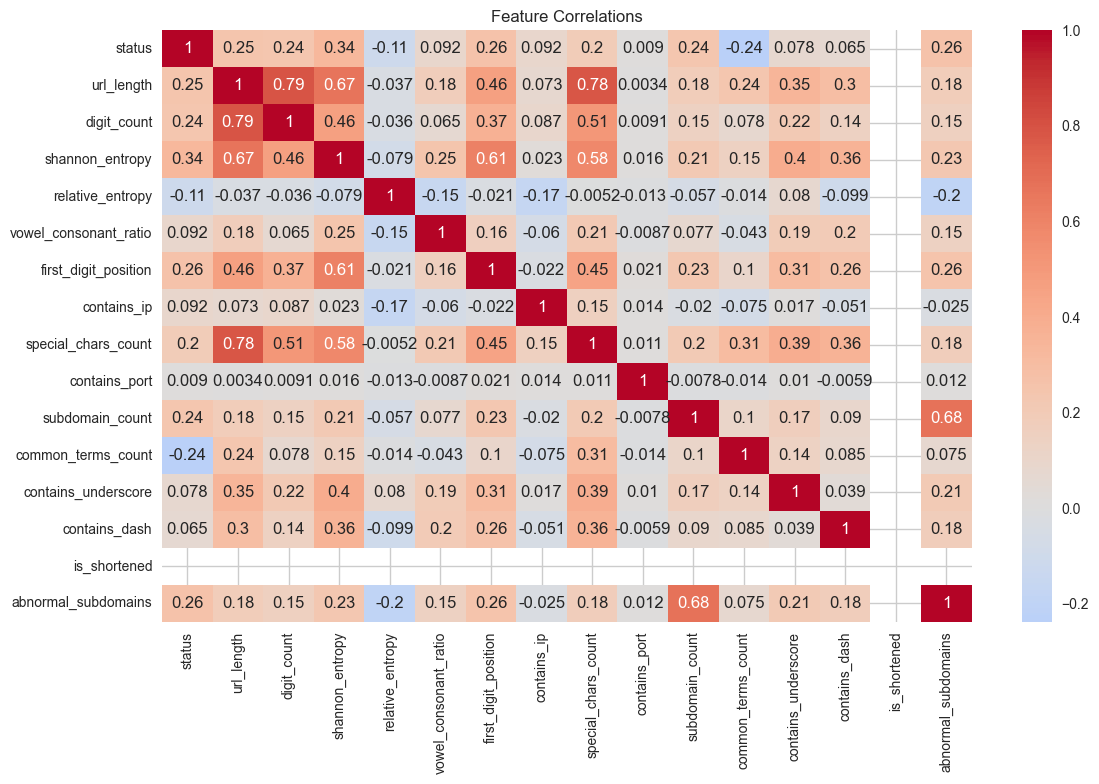

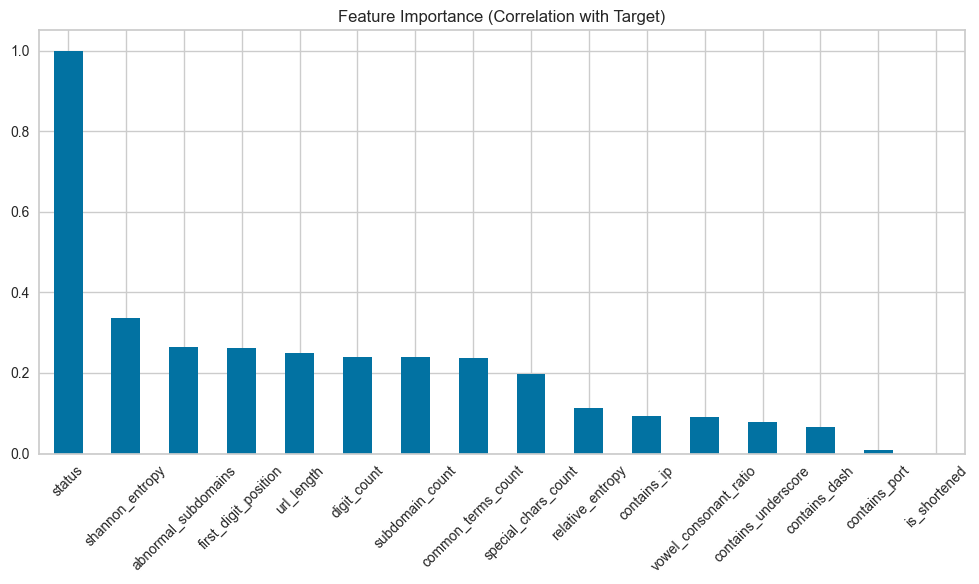


Correlation with target (status):
status                   1.000000
shannon_entropy          0.336562
abnormal_subdomains      0.263705
first_digit_position     0.262694
url_length               0.248482
digit_count              0.240425
subdomain_count          0.240168
common_terms_count       0.237769
special_chars_count      0.197068
relative_entropy         0.113240
contains_ip              0.092139
vowel_consonant_ratio    0.091563
contains_underscore      0.077546
contains_dash            0.065400
contains_port            0.009011
is_shortened                  NaN
Name: status, dtype: float64

Selected features: ['status', 'shannon_entropy', 'abnormal_subdomains', 'first_digit_position', 'url_length', 'digit_count', 'subdomain_count', 'common_terms_count', 'special_chars_count', 'relative_entropy']
Original shape: (11430, 16)
Cleaned shape: (11430, 10)


In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

def analyze_features(df):
    # Create copy and encode target
    df_analysis = df.copy()
    le = LabelEncoder()
    df_analysis['status'] = le.fit_transform(df_analysis['status'])
    
    # Check for duplicates
    duplicates = df_analysis.duplicated().sum()
    print(f"Duplicated rows: {duplicates}")
    
    # Calculate variances
    variances = df_analysis.var()
    print("\nFeatures with low variance (<0.01):")
    print(variances[variances < 0.01])
    
    # Correlation analysis
    corr = df_analysis.corr()
    
    # Plot correlation heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
    plt.title('Feature Correlations')
    plt.tight_layout()
    plt.show()

    # Feature importance based on correlation with target
    target_corr = abs(corr['status']).sort_values(ascending=False)
    
    plt.figure(figsize=(10, 6))
    target_corr.plot(kind='bar')
    plt.title('Feature Importance (Correlation with Target)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    print("\nCorrelation with target (status):")
    print(target_corr)
    
    # Find highly correlated feature pairs
    upper_corr = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    redundant = [(col1, col2) for col1 in upper_corr.columns 
                for col2 in upper_corr.index 
                if upper_corr.loc[col2, col1] > 0.8]
    
    if redundant:
        print("\nHighly correlated feature pairs:")
        for f1, f2 in redundant:
            print(f"{f1} - {f2}: {corr.loc[f1, f2]:.3f}")
            
    return target_corr

# Load and analyze data
df = pd.read_csv('dataset_pishing_final.csv')
importance = analyze_features(df)

# Select important features (correlation > 0.1)
important_features = importance[importance > 0.1].index.tolist()

# Create cleaned dataset
df_clean = df[important_features]
print("\nSelected features:", important_features)
print(f"Original shape: {df.shape}")
print(f"Cleaned shape: {df_clean.shape}")

# Save cleaned dataset
df_clean.to_csv('dataset_phishing_cleaned.csv', index=False)

#### 3. ¿Qué columnas o características fueron seleccionadas y por qué?
R// Al ver las gráficas y los resultados obtenidos anteriormente se encontró que hay varias columnas, filas repetidas, de tal forma que estas seran eliminadas. Además, al poder ver cada variable generada, encontramos que hay caracteristicas, filas, columnas las cuales fueron escogidas para ser eliminadas las cuales son contains_ip, vowel_consonant_ratio, contains_underscore, contains_dash, contains_port. Porque aparentemente muestran caracteristicas no tan aceptables para los modelos que vamos a realizar también debido a que estas tienden a mantenerse en un solo rango y nos muestran que no hay una variabilidad en estos que generen una posible característica identificable. La caracteristicas que vamos a usar es 'status', 'shannon_entropy', 'abnormal_subdomains', 'first_digit_position', 'url_length', 'digit_count', 'subdomain_count', 'common_terms_count', 'special_chars_count', 'relative_entropy'

# Parte 2 – Implementación
#### Cargando datos

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Cargar el conjunto de datos
data = pd.read_csv('dataset_phishing_cleaned.csv')

data



,status,shannon_entropy,abnormal_subdomains,first_digit_position,url_length,digit_count,subdomain_count,common_terms_count,special_chars_count,relative_entropy
0,legitimate,3.787043,False,-1,37,0,0,3,7,1.221603
1,phishing,4.419864,False,32,77,17,0,2,7,0.792675
2,phishing,4.753412,True,62,126,19,2,4,19,1.117812
3,legitimate,3.461320,False,-1,18,0,0,1,5,1.919763
4,legitimate,4.097662,False,-1,55,0,0,3,10,1.778614
...,...,...,...,...,...,...,...,...,...,...
11425,legitimate,4.119088,False,-1,45,0,0,3,7,1.186465
11426,phishing,4.938590,False,44,84,2,0,4,15,1.351302
11427,legitimate,4.987577,False,64,105,15,0,4,17,1.796745
11428,legitimate,4.214132,False,-1,38,0,0,3,6,0.571938


In [ ]:
data.describe()

,shannon_entropy,first_digit_position,url_length,digit_count,subdomain_count,common_terms_count,special_chars_count,relative_entropy
count,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000
mean,4.233349,15.152143,61.120035,5.452143,0.184864,2.799563,9.978740,1.616653
std,0.413293,23.777508,55.292470,16.319904,0.688161,1.068230,6.161914,0.794864
min,2.952820,-1.000000,12.000000,0.000000,0.000000,1.000000,4.000000,-0.071964
25%,3.967586,-1.000000,33.000000,0.000000,0.000000,2.000000,6.000000,1.096123
50%,4.188331,-1.000000,47.000000,0.000000,0.000000,3.000000,8.000000,1.442551
75%,4.453156,30.000000,71.000000,5.000000,0.000000,3.000000,12.000000,1.986905
max,5.996952,239.000000,1641.000000,679.000000,12.000000,14.000000,145.000000,7.141480


# Separación de datos

In [16]:
# Dividir los datos en conjunto de entrenamiento, validación y prueba
train_val_data, test_data = train_test_split(data, test_size=0.3, random_state=42) 
train_data, val_data = train_test_split(train_val_data, test_size=0.15, random_state=42) 

# Almacenar cada conjunto como un archivo .csv
train_data.to_csv('train_data.csv', index=False) # No incluir el índice
val_data.to_csv('val_data.csv', index=False) # No incluir el índice
test_data.to_csv('test_data.csv', index=False) # No incluir el índice

In [17]:
# Cargar datos de entrenamiento
train_data = pd.read_csv("train_data.csv")

# Cargar datos de validación
val_data = pd.read_csv("val_data.csv")

# Cargar datos de prueba
test_data = pd.read_csv("test_data.csv")

In [18]:
train_data


,status,shannon_entropy,abnormal_subdomains,first_digit_position,url_length,digit_count,subdomain_count,common_terms_count,special_chars_count,relative_entropy
0,legitimate,4.236509,False,-1,57,0,0,3,8,1.048696
1,phishing,3.671406,False,14,26,2,0,2,6,1.400073
2,legitimate,4.399832,False,41,123,6,0,3,24,1.566079
3,legitimate,4.141622,False,22,37,1,0,2,5,1.388310
4,phishing,4.999065,False,31,158,60,0,3,18,1.572658
...,...,...,...,...,...,...,...,...,...,...
6795,legitimate,3.913401,False,-1,31,0,0,3,6,0.913116
6796,legitimate,4.039149,False,-1,28,0,0,3,6,1.523553
6797,legitimate,3.810081,False,-1,27,0,0,4,6,1.568243
6798,legitimate,4.530632,False,20,68,8,0,2,14,2.456521


In [19]:
val_data

,status,shannon_entropy,abnormal_subdomains,first_digit_position,url_length,digit_count,subdomain_count,common_terms_count,special_chars_count,relative_entropy
0,phishing,4.811715,True,58,121,27,3,5,18,1.272573
1,legitimate,4.149567,False,-1,79,0,0,3,13,1.610575
2,phishing,4.048034,False,-1,46,0,0,2,8,3.359010
3,phishing,3.930007,False,-1,41,0,0,3,8,2.920078
4,legitimate,4.421850,False,24,69,2,0,3,14,1.472515
...,...,...,...,...,...,...,...,...,...,...
1196,phishing,4.647361,False,41,83,6,0,3,20,2.380872
1197,phishing,4.154896,False,-1,79,0,0,5,13,2.011462
1198,legitimate,3.989898,False,-1,30,0,0,3,6,0.839700
1199,phishing,4.244205,False,46,77,1,0,4,13,1.016186


In [20]:
test_data

,status,shannon_entropy,abnormal_subdomains,first_digit_position,url_length,digit_count,subdomain_count,common_terms_count,special_chars_count,relative_entropy
0,legitimate,4.036007,False,-1,35,0,0,4,7,2.555047
1,legitimate,3.663533,False,-1,22,0,0,2,5,1.700537
2,legitimate,4.580578,False,-1,43,0,0,4,9,1.956464
3,legitimate,3.844107,False,17,26,4,0,3,6,1.237985
4,phishing,4.365430,False,49,62,1,0,2,13,1.701834
...,...,...,...,...,...,...,...,...,...,...
3424,phishing,4.316827,False,34,39,2,0,1,8,3.585364
3425,legitimate,4.307433,False,-1,63,0,0,2,8,4.055929
3426,phishing,4.742084,False,11,229,22,0,4,42,1.834796
3427,legitimate,4.091732,False,-1,64,0,0,3,11,1.088068


# Implementación
mplemente dos modelos de Machine Learning (a su discreción) para la clasificación de phishing.
Muestre y explique los valores obtenidos de las siguientes métricas para los datos de validación y pruebas, para cada modelo, en base al contexto del problema (detección de Pishing).

• Matriz de confusión

• Precision

• Recall

• Curva ROC

• AUC

# Modelo 1 - Random Forest

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, auc

# Separar las características y la variable objetivo
X_train = train_data.drop('status', axis=1)
y_train = train_data['status']

X_val = val_data.drop('status', axis=1)
y_val = val_data['status']

X_test = test_data.drop('status', axis=1)
y_test = test_data['status']

# Definir el modelo de Random Forest
rf_classifier = RandomForestClassifier(random_state=42, class_weight='balanced')

# Definir los hiperparámetros a ajustar
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']  # Se corrigió 'auto'
}

# Realizar la búsqueda en cuadrícula
grid_search = GridSearchCV(
    estimator=rf_classifier,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    verbose=2,
    n_jobs=4,  # Reduce carga en CPUs limitadas
    return_train_score=True
)

# Ajustar el modelo a los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros encontrados
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

# Obtener el mejor modelo
best_rf_model = grid_search.best_estimator_

# Evaluar el modelo con el conjunto de validación
val_accuracy = best_rf_model.score(X_val, y_val)
print("Exactitud en conjunto de validación:", val_accuracy)

Fitting 3 folds for each of 162 candidates, totalling 486 fits
Mejores hiperparámetros: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Exactitud en conjunto de validación: 0.7901748542880933


Matriz de Confusión:
 [[1459  273]
 [ 405 1292]]


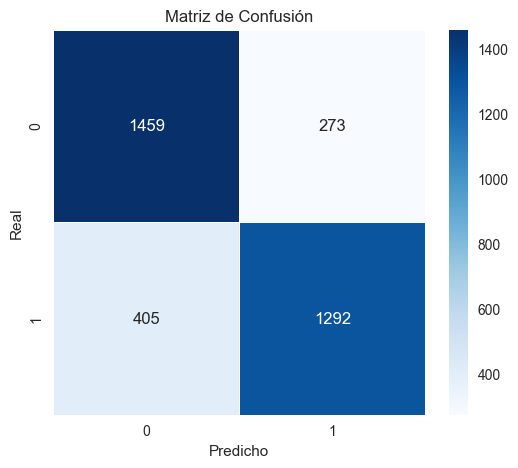

Precisión: 0.804142213659861
Recall: 0.8018611501617445
AUC: 0.886972118981874


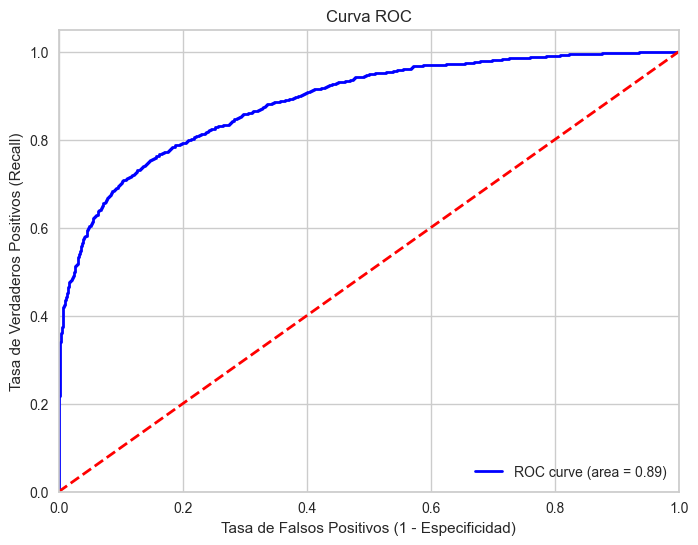

In [31]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import precision_score, recall_score
# Predecir las clases en los datos de prueba
y_pred = best_rf_model.predict(X_test)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de Confusión:\n", conf_matrix)

# Visualizar la matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", linewidths=0.5)
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

# Convertir etiquetas a valores binarios
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test).ravel()  # Convierte a 0 y 1

# Calcular la precisión
precision = precision_score(y_test, y_pred, average="macro")
print("Precisión:", precision)

# Calcular el recall
recall = recall_score(y_test, y_pred, average="macro") 
print("Recall:", recall)

# Calcular la probabilidad de clase 1 para el cálculo de la curva ROC
y_probs = best_rf_model.predict_proba(X_test)[:, 1]

# Calcular la curva ROC y el AUC
fpr, tpr, thresholds = roc_curve(y_test_bin, y_probs, pos_label=1)
roc_auc = auc(fpr, tpr)
print("AUC:", roc_auc)

# Plotear la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (1 - Especificidad)')
plt.ylabel('Tasa de Verdaderos Positivos (Recall)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

## Explicación de los resultados del modelo 1
aqui colocar

# Modelo 2

In [ ]:
# Cod del modelo 2

## Explicación de los resultados del modelo 2
aqui colocar

# Discusión
4. ¿Cuál es el impacto de clasificar un sitio legítimo como phishing?

R// Clasificar un sitio web legítimo como phishing puede tener graves consecuencias tanto para el propietario del sitio como para los usuarios. Para el propietario del sitio, puede dañar su reputación y credibilidad, lo que lleva a una pérdida de confianza y clientes. También puede resultar en que el sitio web sea incluido en la lista negra por los principales navegadores y proveedores de seguridad, lo que dificulta aún más que los usuarios accedan al sitio. Para los usuarios, puede provocarles evitar el sitio web, incluso si necesitan sus servicios o información. Esto puede resultar en la pérdida de oportunidades o acceso a recursos importantes.

5. ¿Cuál es el impacto de clasificar un sitio de phishing como legítimo?

R// Clasificar un sitio de phishing como legítimo tiene un impacto grave y multifacético, ya que expone a los usuarios a riesgos significativos de robo de información personal, financiera o credenciales de acceso. Esto no solo compromete la seguridad individual, sino que también puede generar pérdidas económicas, dañar la reputación de las empresas afectadas y erosionar la confianza en los sistemas de seguridad en línea. Además, facilita la propagación de actividades maliciosas, como el malware o el fraude, lo que amplifica el alcance del daño y dificulta la detección y mitigación de futuros ataques.

6. En base a las respuestas anteriores, ¿Qué métrica elegiría para comparar modelos similares
de clasificación de phishing?

R// En base a las respuestas anteriores, la métrica más adecuada para comparar modelos similares de clasificación de phishing sería el F1-Score, ya que equilibra la precisión y el recall. Esto es crucial porque tanto los falsos positivos (clasificar un sitio legítimo como phishing) como los falsos negativos (clasificar un sitio de phishing como legítimo) tienen consecuencias graves. El F1-Score permite evaluar el rendimiento del modelo considerando ambos errores, asegurando que no se priorice uno sobre el otro y garantizando un equilibrio entre la detección efectiva de phishing y la minimización de clasificaciones incorrectas de sitios legítimos.

7. ¿Qué modelo funcionó mejor para la clasificación de phishing? ¿Por qué?

R//

8. Una empresa desea utilizar su mejor modelo, debido a que sus empleados sufren constantes
ataques de phishing mediante e-mail. La empresa estima que, de un total de 50,000 emails,
un 15% son phishing. ¿Qué cantidad de alarmas generaría su modelo? ¿Cuántas positivas y
cuantas negativas? ¿Funciona el modelo para el BR propuesto? En caso negativo, ¿qué
propone para reducir la cantidad de falsas alarmas?

R//